In [1]:
import numpy as np
import matplotlib.pyplot as plt

## read_ctf option 2

512 384


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


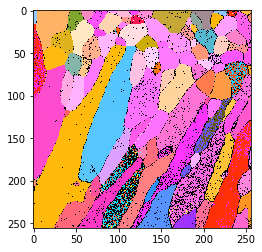

In [7]:
def read_ctf(filename: str, missing_phase: int=None):
    """
    enter the name of the ctf file with extension '.ctf' to read the file
    """
    # TODO docstring
    file = open(filename)
    num_x          = None
    num_y          = None
    num_z          = None
    x_step         = None
    y_step         = None
    z_step         = None
    col_titles     = None
    n_header_lines = None
    for [line_number, line] in enumerate(file):
        split_line = line.split()
        if len(split_line) == 0: continue
        first_word = split_line[0]
        if   first_word == "XCells": num_x  = int(  split_line[1])
        elif first_word == "YCells": num_y  = int(  split_line[1])
        elif first_word == "ZCells": num_z  = int(  split_line[1])
        elif first_word == "XStep" : x_step = float(split_line[1])
        elif first_word == "YStep" : y_step = float(split_line[1])
        elif first_word == "ZStep" : z_step = float(split_line[1])
        # TODO what if CTF format spec doesn't require "Phase" to be in the
        # first column? Then this approach to detecting the data group header
        # can fail on perfectly valid files
        elif first_word == "Phase":
            col_titles = split_line
            # we expect this to be the last line in the header
            n_header_lines = line_number + 1 # line_number indexing is 0-based
            break
    file.close()
    print(num_x, num_y)
    if num_x  is None: raise ValueError("Failed to find XCells in header.")
    if num_y  is None: raise ValueError("Failed to find YCells in header.")
    if x_step is None: raise ValueError("Failed to find XStep in header.")
    if y_step is None: raise ValueError("Failed to find YStep in header.")
    volumetric = num_z is not None and num_z > 0
    if volumetric and z_step is None:
        raise ValueError("Failed to find ZStep in header.")
    if col_titles is None:
        raise ValueError("Failed to find data group header "
                         "(i.e. column titles).")
    try:
        x_col = col_titles.index("X")
        y_col = col_titles.index("Y")
        if volumetric: z_col = col_titles.index("Z")
        ang_cols = (col_titles.index("Euler1"),
                    col_titles.index("Euler2"),
                    col_titles.index("Euler3"))
        phase_col = 0 # TODO assumption. Does .ctf spec actually guarantee this?
    except ValueError as err:
        raise ValueError(f"Failed to find field {err.args[0].split()[0]} in "
                          "data group header (i.e. column titles).")

    data = np.loadtxt(filename, skiprows=n_header_lines)
    # TODO should the following 3 lines use `.nanmin()`? How do we even handle a
    # file containing nans?
    min_x = data[:, x_col].min()
    min_y = data[:, y_col].min()
#     x_inds = ( (data[:, x_col] - min_x) / x_step ).astype(int)
#     y_inds = ( (data[:, y_col] - min_y) / y_step ).astype(int)
    
    x_inds = np.array([i for j in range(num_y) for i in range(num_x)]); #print(x_inds[:50],'\n', x_inds_test[:50])
    y_inds = np.array([j for j in range(num_y) for i in range(num_x)]); #print(y_inds[:50],'\n', y_inds_test[:50])
    
    if volumetric:
        min_z = data[:, z_col].min()
        z_inds = ( (data[:, z_col] - min_z) / z_step ).astype(int)
        angles_shape = (num_x, num_y, num_z, 3)
        inds = (x_inds, y_inds, z_inds, slice(None))
    else:
        angles_shape = (num_x, num_y, 3)
        inds = (x_inds, y_inds, slice(None))
    # in case data doesn't exist for some indices
    angles = np.full(angles_shape, np.nan)
    angles[inds] = data[:, ang_cols]
    
    if missing_phase is None:
        # TODO is it safe to assume that any (0, 0, 0) Euler angles indicate a
        # missing value? It is theoretically possible for this to be known data
        missing_inds = np.all(angles == 0, axis=angles.ndim-1)
    else:
        missing_rows = data[:, phase_col] == missing_phase
        if volumetric:
            missing_inds = (x_inds[missing_rows],
                            y_inds[missing_rows],
                            z_inds[missing_rows],
                            slice(None))
        else:
            missing_inds = (x_inds[missing_rows],
                            y_inds[missing_rows],
                            slice(None))
        
    angles[missing_inds] = np.nan
    return angles


# Example usage
file_path = './HDEDT8H Specimen 1 Site 1 Map Data 1 B.ctf'
x = np.deg2rad(read_ctf(file_path))
plt.imshow(x[256:,128:,:])

## Write ctf using template

In [8]:
def save_ang_data_as_ctf(filename, angles, xstep=1, ystep=1,
                  phase=None, mad=None, bc=None, bs=None, bands=None, error=None,
                  original_file=None, n_header_lines=15):
    """
    Enter the name of the ctf file you intend to give with the .ctf extention as a string the first variable,
    the second variable is the angle data array.
    filename: string of filename with the filepath
    """
    nx,ny = angles.shape[:2]
    int_zeros_array = np.zeros((nx,ny), dtype=int)

    if original_file is not None:
        f = open( original_file, 'rt' )
        header_lines = []
        for line in f:
            if line.split()[0] == 'Phase':
                header_lines.append(line)
                break
            header_lines.append(line)
        f.close()
        
        for line in header_lines:
            print(line)
            if line.startswith('XStep'):  xstep = float( line.split('\t')[1] )
            if line.startswith('YStep'):  ystep = float( line.split('\t')[1] )

    if phase is None:  phase = np.ones_like(int_zeros_array)
    if bands is None:  bands = int_zeros_array
    if error is None:  error = int_zeros_array
    if bc is None:  bc = int_zeros_array
    if bs is None:  bs = int_zeros_array
    if mad is None:  mad = np.ones((nx,ny), dtype=float)

    
    f = open(filename, 'wt')

    if original_file is not None:
        f.writelines( header_lines )
    else:
        f.write('Channel Text File\n')
        f.write('Prj\tC:\%s\n' % filename)
        f.write('Author	Unknown\n')
        f.write('JobMode\tGrid\n')
        f.write('XCells\t%d\nYCells\t%d\n' % (nx,ny))
        f.write('XStep\t%3.1f\nYStep\t%3.1f\n' % (xstep,ystep))
        f.write('AcqE1\t0\nAcqE2\t0\nAcqE3\t0\n')
        f.write('Euler angles refer to Sample Coordinate system (CS0)!\t'
                'Mag\t90\tCoverage\t100\tDevice\t0\t'
                'KV\t30\tTiltAngle\t70\tTiltAxis\t0\n')
        f.write('Phases	1\n')
        f.write('2.951;2.951;4.684\t90;90;120\tTitanium\t9\t194\t?\t'
                '??????.?.?	?????	Publication Info ???\n')
        f.write('Phase\tX\tY\tBands\tError\tEuler1\tEuler2\tEuler3\tMAD\tBC\tBS\n')

    angles = np.rad2deg(angles); angles[np.isnan(angles)] = 0
    for j in range(ny):
        for i in range(nx):
            x = i * xstep
            y = j * ystep
            euler1, euler2, euler3 = angles[i,j,:]
            if euler1 == 0 and euler2==0 and euler3 == 0: mad[i,j] = 0
            f.write("%d\t%s\t%s\t%d\t%d\t%s\t%s\t%s\t%s\t%d\t%d\n" %
                    (phase[i,j], str('%6.4f' % x)[:6], str('%6.4f' % y)[:6],
                     bands[i,j], error[i,j], str('%6.4f' % euler1)[:6],
                     str('%6.4f' % euler2)[:6], str('%6.4f' % euler3)[:6],
                     str('%6.4f' % mad[i,j])[:6], bc[i,j], bs[i,j] ))            
    f.close()





    


    
save_ang_data_as_ctf('./output_test.ctf', x[256:,128:,:], original_file='./HDEDT8H Specimen 1 Site 1 Map Data 1 B.ctf')

﻿Channel Text File

Prj	D:\oyerinoe\HEA\EBSD\05192022\HDEDT8H\HDEDT8H.oip

Author	[Author]

JobMode	Grid

XCells	512

YCells	384

XStep	1.548353

YStep	1.548353

AcqE1	0

AcqE2	0

AcqE3	0

Euler angles refer to Sample Coordinate system (CS0)!	Mag	150	Coverage	94.19	Device	0	KV	20	TiltAngle	1.26972703082587	TiltAxis	0

Phases	3

3.6599;3.6599;3.6599	90;90;90	Fe-FCC	11	225			Z. Angew. Phys. [ZAPHAX], vol. 23, pages 245-249

2.866;2.866;2.866	90;90;90	Fe-BCC	11	229			J. Appl. Phys. [JAPIAU], vol. 42, pages 4290-4295

8.79;8.79;4.56	90;90;90	HEA Sigma	5	136			Sigma Phase Prototype based on beta-Uramium

Phase	X	Y	Bands	Error	Euler1	Euler2	Euler3	MAD	BC	BS



In [23]:
f = open('./HDEDT8H Specimen 1 Site 1 Map Data 1 B.ctf')
for line in f:
    if line.split()[0] != 'Phase':
        print(line)
    break

﻿Channel Text File

